In [100]:
import torch
from torch import nn
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

from torchmetrics import Accuracy

from utilities.helper_functions import plot_decision_boundary

from pathlib import Path

torch.__version__

'2.7.1+cu118'

### Agnostic device

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Accuracy metrics

In [19]:
accuracy = Accuracy(task="binary").to(device)

In [28]:
# Make a binary classification dataset with Scikit-Learn's make_moons() function.
# For consistency, the dataset should have 1000 samples and a random_state=42.
# Turn the data into PyTorch tensors.
# Split the data into training and test sets using train_test_split with 
# 80% training and 20% testing.

n_samples = 1000
RANDOM_SEED = 42

X, y = make_moons(
    n_samples,
    random_state=RANDOM_SEED
)


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.8,
    random_state=RANDOM_SEED
)

In [29]:
def numpy_to_tensor():

    global X_train, X_test, y_train, y_test

    X_train = torch.from_numpy(X_train).type(torch.float32)
    X_test = torch.from_numpy(X_test).type(torch.float32)
    y_train = torch.from_numpy(y_train).type(torch.float32)
    y_test = torch.from_numpy(y_test).type(torch.float32)

In [30]:
numpy_to_tensor()

In [31]:
def put_data_on(device):

    global X_train, X_test, y_train, y_test
    X_train = X_train.to(device)
    X_test = X_test.to(device)
    y_train = y_train.to(device)
    y_test = y_test.to(device)

In [32]:
print(X_train.device)
put_data_on(device)
X_train.device

cpu


device(type='cuda', index=0)

In [33]:
print(X_train.device)
put_data_on("cpu")
X_train.device

cuda:0


device(type='cpu')

In [34]:
put_data_on(device)

### Let's plot the data to visualize

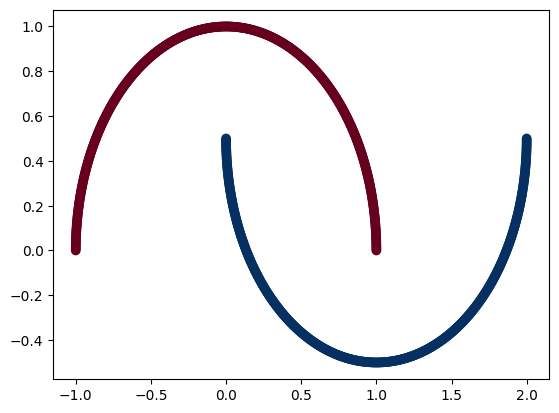

In [35]:
plt.scatter(X[:, 0], X[:, 1], c=y , cmap=plt.cm.RdBu)

2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [94]:
class MoonsClassificationV1(nn.Module):

    def __init__(self, hidden_units):
        super().__init__()

        self.layer_stack = nn.Sequential(

            nn.Linear(in_features=2, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=1)
        )

    def forward(self, x:torch.tensor) -> torch.tensor:

        return self.layer_stack(x)

model_0 = MoonsClassificationV1(30).to(device)
model_0

MoonsClassificationV1(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=1, bias=True)
  )
)

3. Setup a binary classification compatible loss function and optimizer to use when training the model.

In [95]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.

* To measure model accuracy, you can create your own accuracy function or use the accuracy function in TorchMetrics.

* Train the model for long enough for it to reach over 96% accuracy.

* The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [96]:
logits = model_0(X_test).squeeze()
preds = torch.round(torch.sigmoid(logits))
loss = loss_fn(logits, y_test)

logits[:5], preds[:5], y_test[:5]

(tensor([-0.0627, -0.1253, -0.0845, -0.1311, -0.1227], device='cuda:0',
        grad_fn=<SliceBackward0>),
 tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SliceBackward0>),
 tensor([1., 0., 1., 0., 1.], device='cuda:0'))

In [97]:
def fit_fn(epochs):

    for epoch in range(epochs):

        model_0.train()

        train_logits = model_0(X_train).squeeze()
        trian_preds = torch.round(torch.sigmoid(train_logits))
        train_loss = loss_fn(train_logits, y_train)
        train_accuracy = accuracy(trian_preds, y_train)

        optimizer.zero_grad()

        train_loss.backward()

        optimizer.step()


        ## Testing

        accuracy.reset()

        model_0.eval()

        with torch.inference_mode():

            test_logits = model_0(X_test).squeeze()
            test_preds = torch.round(torch.sigmoid(test_logits))
            test_loss = loss_fn(test_logits, y_test)
            test_accuracy = accuracy(test_preds, y_test)

            if epoch % 10 == 0:

                print(f"Epoch: {epoch} --- | Train Loss: {train_loss: .5f} --- | Train Accuracy: {train_accuracy: .2f}% --- | Test Loss: {test_loss: .5f} --- | Test Accuracy: {test_accuracy: .2f}%")

In [98]:
model_0.to(device)
fit_fn(500)

Epoch: 0 --- | Train Loss:  0.68966 --- | Train Accuracy:  0.50% --- | Test Loss:  0.68754 --- | Test Accuracy:  0.50%
Epoch: 10 --- | Train Loss:  0.67095 --- | Train Accuracy:  0.65% --- | Test Loss:  0.66912 --- | Test Accuracy:  0.70%
Epoch: 20 --- | Train Loss:  0.64320 --- | Train Accuracy:  0.85% --- | Test Loss:  0.64186 --- | Test Accuracy:  0.81%
Epoch: 30 --- | Train Loss:  0.59769 --- | Train Accuracy:  0.86% --- | Test Loss:  0.59691 --- | Test Accuracy:  0.82%
Epoch: 40 --- | Train Loss:  0.52327 --- | Train Accuracy:  0.86% --- | Test Loss:  0.52429 --- | Test Accuracy:  0.84%
Epoch: 50 --- | Train Loss:  0.43431 --- | Train Accuracy:  0.86% --- | Test Loss:  0.43921 --- | Test Accuracy:  0.85%
Epoch: 60 --- | Train Loss:  0.35663 --- | Train Accuracy:  0.86% --- | Test Loss:  0.36574 --- | Test Accuracy:  0.86%
Epoch: 70 --- | Train Loss:  0.30658 --- | Train Accuracy:  0.86% --- | Test Loss:  0.31709 --- | Test Accuracy:  0.88%
Epoch: 80 --- | Train Loss:  0.27590 --- 

### Model evaluation

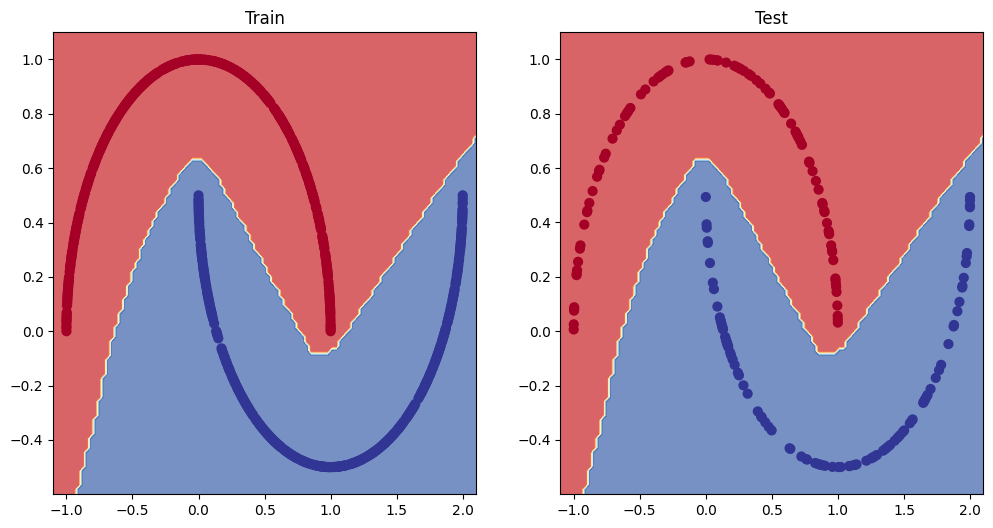

In [99]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)


plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### save model

In [104]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "05-moons-binary-classification.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model at: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model at: models\05-moons-binary-classification.pt


### load model

In [107]:
loaded_model_0 = MoonsClassificationV1(30)
loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

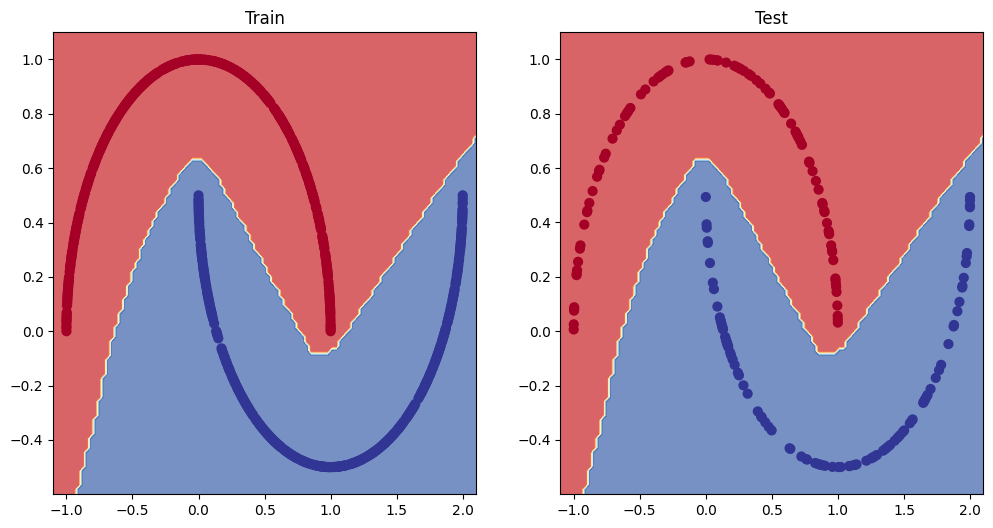

In [108]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(loaded_model_0, X_train, y_train)


plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(loaded_model_0, X_test, y_test)